# INFO212 Assignment2 T22
*Name: Qinru Yang ID: 320220940961  
Name: Rongshen He ID: 320220940271  
Name: Qirui Zhang ID: 320220941080  
Name: Wei Dou ID: 320220940190*  
**Objective**: Develop a Python project to analyze and visualize economic indicatorsfrom JSON data files using Pandas and Seaborn or other visualization libraries.

- **Before you get started, make sure you have downloaded the libraries below**

In [1]:
import requests
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import altair as alt
import seaborn as sns
import warnings
from IPython.core.display import HTML
warnings.filterwarnings("ignore", message="The figure layout has changed to tight")
warnings.filterwarnings("ignore", message="FutureWarning")

## Step1: Data Collection  
- We first call the **World Bank API** to query data on GDP, unemployment rate, inflation, and other metrics for five countries, spanning nearly 40 years. We use the API because most of the existing datasets available online are not in JSON format. Since JSON data is often used for efficient front-end and back-end transmission and contains some unnecessary parameters, we decided to use the API to obtain the dataset in JSON format.   
- We constructs a URL for each country and indicator, sends a request to the World Bank API, and processes the JSON response. The data for each indicator and country is stored in a dictionary.Finally, the combined data is saved into a JSON file named "world_bank_data.json". 

In [2]:
# Define the countries and metrics for the query
countries = ["CN", "BR", "JP", "CA", "NP"]
indicators = {
    "GDP": "NY.GDP.MKTP.CD",
    "Unemployment": "SL.UEM.TOTL.ZS",
    "Inflation": "FP.CPI.TOTL",
    "Tariff rate": "TM.TAX.MANF.SM.AR.ZS",
    "GDP growth": "NY.GDP.MKTP.KD.ZG"
}
years = range(1980, 2019 + 1)
base_url = "http://api.worldbank.org/v2/country/{}/indicator/{}?date={}:{}&format=json&per_page=100"

# Get the data and merge it into a JSON file
data = {}
for indicator_name, indicator_code in indicators.items():
    data[indicator_name] = {}
    for country in countries:
        response = requests.get(base_url.format(country, indicator_code, years[0], years[-1]))
        if response.status_code == 200:
            result = response.json()
            if len(result) > 1:
                data[indicator_name][country] = result[1]
        else:
            print(f"Error fetching data for {country} - {indicator_name}: {response.status_code}")

# Save data to JSON file
with open("world_bank_data.json", "w") as f:
    json.dump(data, f, indent=4)

print("Data has been saved to world_bank_data.json")


Data has been saved to world_bank_data.json


In [3]:
with open("world_bank_data.json", "r") as f:
    data = json.load(f)

## Step2: Data Preparation  
- **Frist, we load the JSON files into Pandas DataFrames**(by indicators). Because JSON data is nested and hierarchical and contains some unnecessary parameters, which can make it challenging to work with directly. 
- So we create `create_indicator_dataframe function`. It iterates through the JSON data for a specific indicator, extracting the country code, date, and corresponding indicator value for each entry. These records are then organized into a DataFrame with columns for country, date, and the specified indicator. 
- Then we create `display_dfs function`. It's used to display and beautify multiple dataframes in a single output. It utilizes the `highlight_null` parameter to highlight missing values. It employs `to_html` to print the dataframes as HTML, making the output easier to observe.

In [4]:
# Country Name Mapping dictionary
country_names = {"CN": "China", "BR": "Brazil", "JP": "Japan", "CA": "Canada", "NP": "Nepal"}

def create_indicator_dataframe(data, indicator):
    records = [(country_names[country_code], int(entry['date']), entry['value']) for country_code, values in data[indicator].items() for entry in values]
    df = pd.DataFrame(records, columns=['country', 'date', indicator])
    df_pivot = df.pivot(index='date', columns='country', values=indicator)
    return df_pivot

# Create a GDP, Unemployment, Inflation DataFrame
gdp_df = create_indicator_dataframe(data, "GDP")
unemployment_df = create_indicator_dataframe(data, "Unemployment")
inflation_df = create_indicator_dataframe(data, "Inflation")
tariff_df = create_indicator_dataframe(data, "Tariff rate")
gdp_growth_df = create_indicator_dataframe(data, "GDP growth")
    
def display_dfs(df, title):
    df_list = {}
    for _df, _title in zip(df, title):
        df_list[_title] = _df.style.highlight_null(null_color='#B0E0E6').set_caption(_title)
    for _title, _df in df_list.items():
        display(HTML(_df.to_html()))


# Call the display_dfs function to output all dataframes at once
display_dfs([gdp_df, unemployment_df, inflation_df, tariff_df, gdp_growth_df]
            , ["GDP DataFrame", "Unemployment DataFrame", "Inflation DataFrame", "Tariff rate DataFrame", "GDP growth DataFrame"])

country,Brazil,Canada,China,Japan,Nepal
date,,,,,
1980,nan,274776566028.053009,306165314855.846008,1129377244854.040039,1945916583.333330
1981,nan,307246642755.859009,289576581830.448975,1245221410764.149902,2275583316.666670
1982,nan,314647807408.607971,283928672988.111023,1158731426905.850098,2395423680.228520
1983,nan,341866277182.732971,304748904221.289001,1270859919742.899902,2447174803.540510
1984,nan,356718400123.543030,313728547706.896973,1345824500836.760010,2581207387.797090
1985,nan,366186012449.651978,309835803013.586975,1427019759717.409912,2619913955.515560
1986,nan,379006836991.723999,300514204520.968994,2120083812109.909912,2850782092.693870
1987,nan,433134238310.708984,327089403146.072998,2580748422781.089844,2957255379.543150
1988,nan,509380027626.554016,407844670393.057983,3125724434400.790039,3487009748.356380


country,Brazil,Canada,China,Japan,Nepal
date,,,,,
1980,nan,nan,nan,nan,nan
1981,nan,nan,nan,nan,nan
1982,nan,nan,nan,nan,nan
1983,nan,nan,nan,nan,nan
1984,nan,nan,nan,nan,nan
1985,nan,nan,nan,nan,nan
1986,nan,nan,nan,nan,nan
1987,nan,nan,nan,nan,nan
1988,nan,nan,nan,nan,nan


country,Brazil,Canada,China,Japan,Nepal
date,,,,,
1980,0.000000,37.807670,nan,77.162600,8.998772
1981,0.000000,42.522896,nan,80.952953,10.001672
1982,0.000000,47.102175,nan,83.171906,11.171723
1983,0.000000,49.864053,nan,84.751939,12.554473
1984,0.000000,52.010590,nan,86.668701,12.911747
1985,0.000000,54.071265,nan,88.430049,13.951483
1986,0.000000,56.339439,26.048320,88.956727,16.602119
1987,0.000000,58.793646,27.932612,89.068970,18.386901
1988,0.000002,61.161992,33.187245,89.673354,20.038597


country,Brazil,Canada,China,Japan,Nepal
date,,,,,
1980,nan,nan,nan,nan,nan
1981,nan,nan,nan,nan,nan
1982,nan,nan,nan,nan,nan
1983,nan,nan,nan,nan,nan
1984,nan,nan,nan,nan,nan
1985,nan,nan,nan,nan,nan
1986,nan,nan,nan,nan,nan
1987,nan,nan,nan,nan,nan
1988,nan,nan,nan,3.960000,nan


country,Brazil,Canada,China,Japan,Nepal
date,,,,,
1980,9.200000,2.177199,7.834145,2.817591,-2.319394
1981,-4.250000,3.415065,5.112761,4.260624,8.341974
1982,0.830000,-3.166150,9.017114,3.279743,3.779375
1983,-2.930000,2.562254,10.770203,3.630199,-2.977406
1984,5.400000,5.898569,15.191540,4.410880,9.681130
1985,7.850000,4.737681,13.430678,5.159808,6.144905
1986,7.490000,2.121481,8.949962,3.294048,4.565651
1987,3.530000,4.072016,11.657428,4.648861,1.695618
1988,-0.060000,4.410839,11.222595,6.661637,7.696809


- Notice that there are many missing values that have been highlighted in light blue in the table above.So we create `clear_Nan function` to clear the nan data in the dataframe. It creates a **mask** indicating the locations of NaN values, replaces them with the specified value, and then returns the mask.
- **`Note`: At this point, we get cleaned, well-formed Dataframes, all of which are stored in the dfs dictionary.**

In [5]:
def clear_Nan(df,value=0):
    Nan_mask = df.isna()
    df[Nan_mask] = value
    return Nan_mask

dfs = dict(zip(["GDP DataFrame", "Unemployment DataFrame", "Inflation DataFrame", "Tariff rate DataFrame", "GDP growth DataFrame"]
               , [gdp_df, unemployment_df, inflation_df, tariff_df, gdp_growth_df]))
for df in dfs.values():
    clear_Nan(df, 0)

## Step3: Data Analysis
- We perform exploratory data analysis (EDA) to understand the datasets. 
- The purpose of this **Exploratory Data Analysis (EDA)** code is to summarize and understand the relationships between different economic indicators for various countries over a specified period. By calculating descriptive statistics and correlation matrices, we aim to identify patterns, trends, and potential relationships among these indicators.

- To **get a summary of key statistics (mean, standard deviation, min, max)** for each indicator DataFrame.We directly call the pandas function `describe()` to show the data distribution of each indicator, it could tell us the important features of data like mean and std. The statistics we get is stored in `dfs_summary`. 

In [6]:
dfs_summary = {}

for (name,df) in dfs.items():
    dfs_summary[name] = df.describe()
display_dfs(dfs_summary.values(), dfs_summary.keys())

country,Brazil,Canada,China,Japan,Nepal
count,40.000000,40.000000,40.000000,40.000000,40.000000
mean,950475755554.892578,954144577189.869507,3534644162818.860352,4070476970661.221680,10071952382.136709
std,840043881263.569336,540811136966.942993,4405534148271.839844,1469988285577.757080,9437549106.365099
min,0.000000,274776566028.053009,283928672988.111023,1129377244854.040039,1945916583.333330
25%,403150971309.518005,576093169615.360840,411992751614.119263,3170859601098.084961,3515671811.831993
50%,662368828394.916992,708696994313.244995,1152671067253.620117,4558345699696.529297,5263947296.005489
75%,1720814683327.167480,1534243479110.984863,5348066279953.450195,5000017567691.787109,13641903206.675951
max,2616156223977.470215,1846597421834.979980,14279968506242.800781,6272362996105.030273,34186180695.996899


country,Brazil,Canada,China,Japan,Nepal
count,40.000000,40.000000,40.000000,40.000000,40.000000
mean,6.639525,5.682500,2.864750,2.771250,7.727600
std,4.475284,3.783724,1.907509,1.924971,4.819939
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.805000,6.985000,3.255000,3.260000,10.655000
75%,10.250000,7.790000,4.535000,4.382500,10.666250
max,12.790000,11.380000,4.720000,5.390000,10.682000


country,Brazil,Canada,China,Japan,Nepal
count,40.000000,40.000000,40.000000,40.000000,40.000000
mean,58.253041,81.457677,69.369470,97.541729,67.052250
std,54.751145,21.642812,39.709831,7.310468,52.658025
min,0.000000,37.807670,0.000000,77.162600,8.998772
25%,0.000677,66.512235,40.140815,93.828495,23.159284
50%,50.803137,80.806382,81.261160,100.681781,55.079209
75%,96.402236,98.690612,98.224998,102.253180,93.601846
max,167.397860,116.757298,125.083154,105.484268,188.729977


country,Brazil,Canada,China,Japan,Nepal
count,40.000000,40.000000,40.000000,40.000000,40.000000
mean,13.150750,3.071500,8.843750,2.098250,7.331000
std,9.427750,2.936415,10.350033,1.175759,7.428742
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.590000,0.000000,0.000000,2.030000,0.000000
50%,14.010000,2.920000,7.955000,2.395000,11.160000
75%,15.342500,4.415000,11.045000,2.787500,12.702500
max,44.420000,10.640000,40.750000,3.960000,23.230000


country,Brazil,Canada,China,Japan,Nepal
count,40.000000,40.000000,40.000000,40.000000,40.000000
mean,2.403548,2.396318,9.440715,1.870137,4.503492
std,3.330191,1.959001,2.735430,2.265391,2.640425
min,-4.350000,-3.166150,3.920251,-5.693236,-2.977406
25%,0.494951,1.793704,7.740025,0.579069,3.476499
50%,2.606843,2.647825,9.249783,1.617979,4.549365
75%,4.522135,3.261607,11.021114,3.351375,6.114706
max,9.200000,5.898569,15.191540,6.661637,9.681130


- Inorder to **get the correlations** between indicators for every country, we iterate over all the dataframes to get new dataframe we needed. We then use `corr method` to calculate the correlation matrix for each country-specific DataFrame.
- In the code below, country_dfs dictionary stores  DataFrame containing all the economic indicators for every country. df_corrs dictionary stores correlation matrix DataFrame for each country.

In [7]:
def create_country_dataframe(dfs, country):
    out_df = pd.DataFrame()
    indicators = dfs.keys()

    for df in dfs.values():
        out_df = pd.concat((out_df,df[country]),axis=1)  # get a dataframe that contains all the indicators
    out_df.columns = indicators
    return out_df

country_dfs = {}
for country in country_names.values(): # iterate throuth all the countries to get dataframes
    country_dfs[country] = create_country_dataframe(dfs,country)
    
df_corrs = {}
for (name,df) in country_dfs.items(): # iterate throuth all the countries to compute correlation matrix
    df_corr = df.corr() # compute correlation matrix
    df_corrs[name] = df_corr

# display all the correlation matrixs
display_dfs(df_corrs.values(), df_corrs.keys())

,GDP DataFrame,Unemployment DataFrame,Inflation DataFrame,Tariff rate DataFrame,GDP growth DataFrame
GDP DataFrame,1.000000,0.629564,0.760270,-0.120913,-0.388229
Unemployment DataFrame,0.629564,1.000000,0.935987,0.317299,-0.049736
Inflation DataFrame,0.760270,0.935987,1.000000,0.215172,-0.251328
Tariff rate DataFrame,-0.120913,0.317299,0.215172,1.000000,0.365621
GDP growth DataFrame,-0.388229,-0.049736,-0.251328,0.365621,1.000000


,GDP DataFrame,Unemployment DataFrame,Inflation DataFrame,Tariff rate DataFrame,GDP growth DataFrame
GDP DataFrame,1.000000,0.599195,0.892347,0.247935,-0.067212
Unemployment DataFrame,0.599195,1.000000,0.755121,0.320915,-0.047503
Inflation DataFrame,0.892347,0.755121,1.000000,0.130586,-0.131907
Tariff rate DataFrame,0.247935,0.320915,0.130586,1.000000,-0.206189
GDP growth DataFrame,-0.067212,-0.047503,-0.131907,-0.206189,1.000000


,GDP DataFrame,Unemployment DataFrame,Inflation DataFrame,Tariff rate DataFrame,GDP growth DataFrame
GDP DataFrame,1.000000,0.835356,0.897638,0.680794,-0.563491
Unemployment DataFrame,0.835356,1.000000,0.803835,0.495917,-0.658705
Inflation DataFrame,0.897638,0.803835,1.000000,0.653784,-0.611186
Tariff rate DataFrame,0.680794,0.495917,0.653784,1.000000,-0.250452
GDP growth DataFrame,-0.563491,-0.658705,-0.611186,-0.250452,1.000000


,GDP DataFrame,Unemployment DataFrame,Inflation DataFrame,Tariff rate DataFrame,GDP growth DataFrame
GDP DataFrame,1.000000,0.409645,0.936333,0.093660,-0.143342
Unemployment DataFrame,0.409645,1.000000,0.595995,0.471881,-0.102753
Inflation DataFrame,0.936333,0.595995,1.000000,0.246614,-0.105046
Tariff rate DataFrame,0.093660,0.471881,0.246614,1.000000,0.082769
GDP growth DataFrame,-0.143342,-0.102753,-0.105046,0.082769,1.000000


,GDP DataFrame,Unemployment DataFrame,Inflation DataFrame,Tariff rate DataFrame,GDP growth DataFrame
GDP DataFrame,1.000000,0.481428,0.977601,0.371648,0.178452
Unemployment DataFrame,0.481428,1.000000,0.611616,0.616641,0.084457
Inflation DataFrame,0.977601,0.611616,1.000000,0.469178,0.146675
Tariff rate DataFrame,0.371648,0.616641,0.469178,1.000000,-0.145362
GDP growth DataFrame,0.178452,0.084457,0.146675,-0.145362,1.000000


## Step4: Data Visualization 

- The code creates a bar chart to visualize GDP data for 5 countries over time. The chart uses different colors for each country and includes an interactive feature for enhanced exploration. Additionally, a red line is overlaid on the bar chart to represent the average GDP growth across all countries, highlighting overall trends. This combined visualization provides a clear comparison of GDP growth by country and year, as well as a general trend line for mean GDP growth.

In [8]:
df = gdp_df.reset_index()
bar = alt.Chart(df).transform_fold(
    ['China','Japan','Brazil','Canada','Nepal',],# rearrange the datas to beautify the chart
    as_=['Country', 'GDP']
).mark_bar(
    opacity=0.7,
    binSpacing=0
).encode(
    x=alt.X('date:O', title='Year'),  # Ordinal for discrete years
    y=alt.Y('GDP:Q', title='GDP').stack(None),
    color=alt.Color('Country:N', title='Country')
).interactive()

# calculate the average GDP of all the countrys the indicate the thrend
mean_df = df.set_index('date').mean(axis=1).reset_index()
mean_df.columns = ['date', 'Mean GDP growth']

mean_line = alt.Chart(mean_df).mark_line(color='red').encode(
    x=alt.X('date:O'),
    y=alt.Y('Mean GDP growth:Q')
)
(bar + mean_line).properties(
    title='GDP Growth by Country and Year'
)

alt.LayerChart(...)

**`Note`: the altair generated images may not be embeded in notebook statically, so we put out the screenshot here (the screenshot url is on the server of my group members).If you want to validate it, just run the cell**
![barchart](http://8.222.204.221/INFO212/HW2/barchart.png)

- Then we explore treads of different indicators across countries

- This code defines a function `draw_line_chart` to create interactive line charts for every indicators across five countries. Each chart displays trends over time, with different colors representing different countries. Tooltips provide detailed information on specific data points. The charts are organized into a grid layout with two charts per row, ensuring a clear and structured visual comparison.

In [9]:
def draw_line_chart(name, df):
    df = df.reset_index()
    long_df = pd.melt(df, id_vars=['date'], var_name='Country', value_name=f'{name}')
    chart = alt.Chart(long_df).mark_line(point={'size': 10}).encode(
        x='date:O',  # 'date:T' if the year is in datetime format
        y=f'{name}:Q',
        color='Country:N',
        tooltip=['Country', 'date', f'{name}']
    ).properties(
        title=f'{name} of Five Countries',
        width=350,  
        height=300 
    ).interactive() # set interactive chart
    return chart

charts = [draw_line_chart(name, df) for name, df in dfs.items()]

# organize the charts into two parts, setting two charts in every part. 
grid = alt.vconcat(
    alt.hconcat(*charts[:2]),
    alt.hconcat(*charts[2:4])
).configure_axis(
    labelFontSize=6,  # Set the axis label font size to 10
    titleFontSize=10  # Set the axis title font size to 12
)


grid.display()

alt.VConcatChart(...)

**`Note`: the altair generated images may not be embeded in notebook statically, so we put out the screenshot here (the screenshot url is on the server of my group members).If you want to validate it, just run the cell**
![linecharts](http://8.222.204.221/INFO212/HW2/linecharts.png)

- The code generates **pair plots using Seaborn** to visualize the relationships between GDPs of different countries. Each pair plot shows how the indicator of one country correlates with the indicators of other countries, highlighting patterns and potential influences between them. The pair plots include both scatter plots and histograms, providing insights into the distribution and pairwise relationships of GDP data.

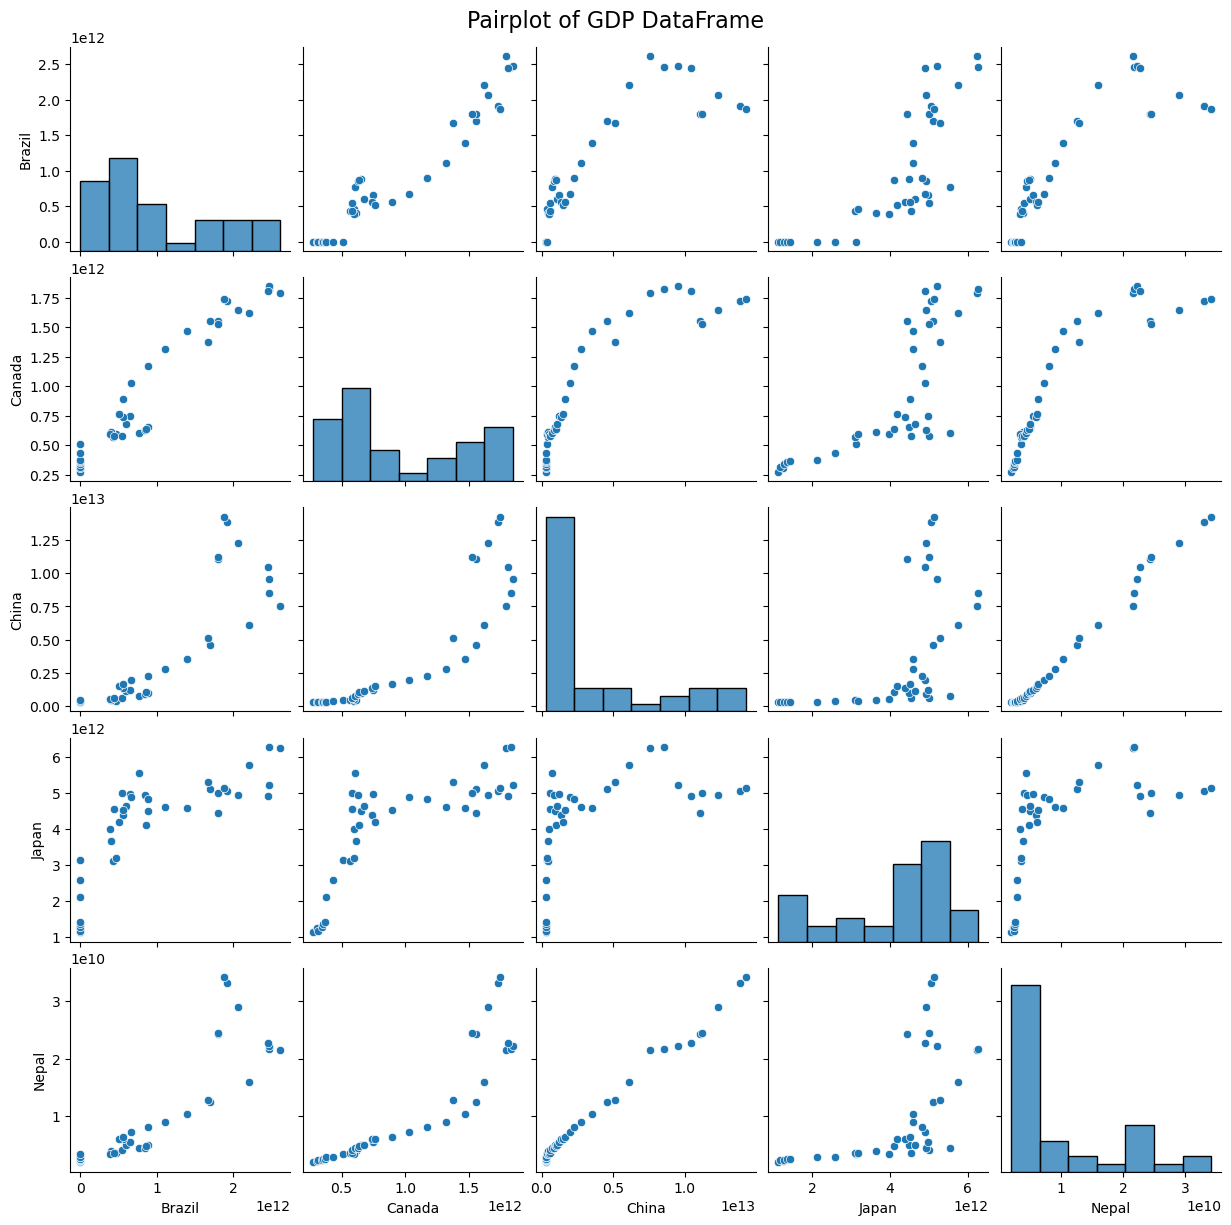

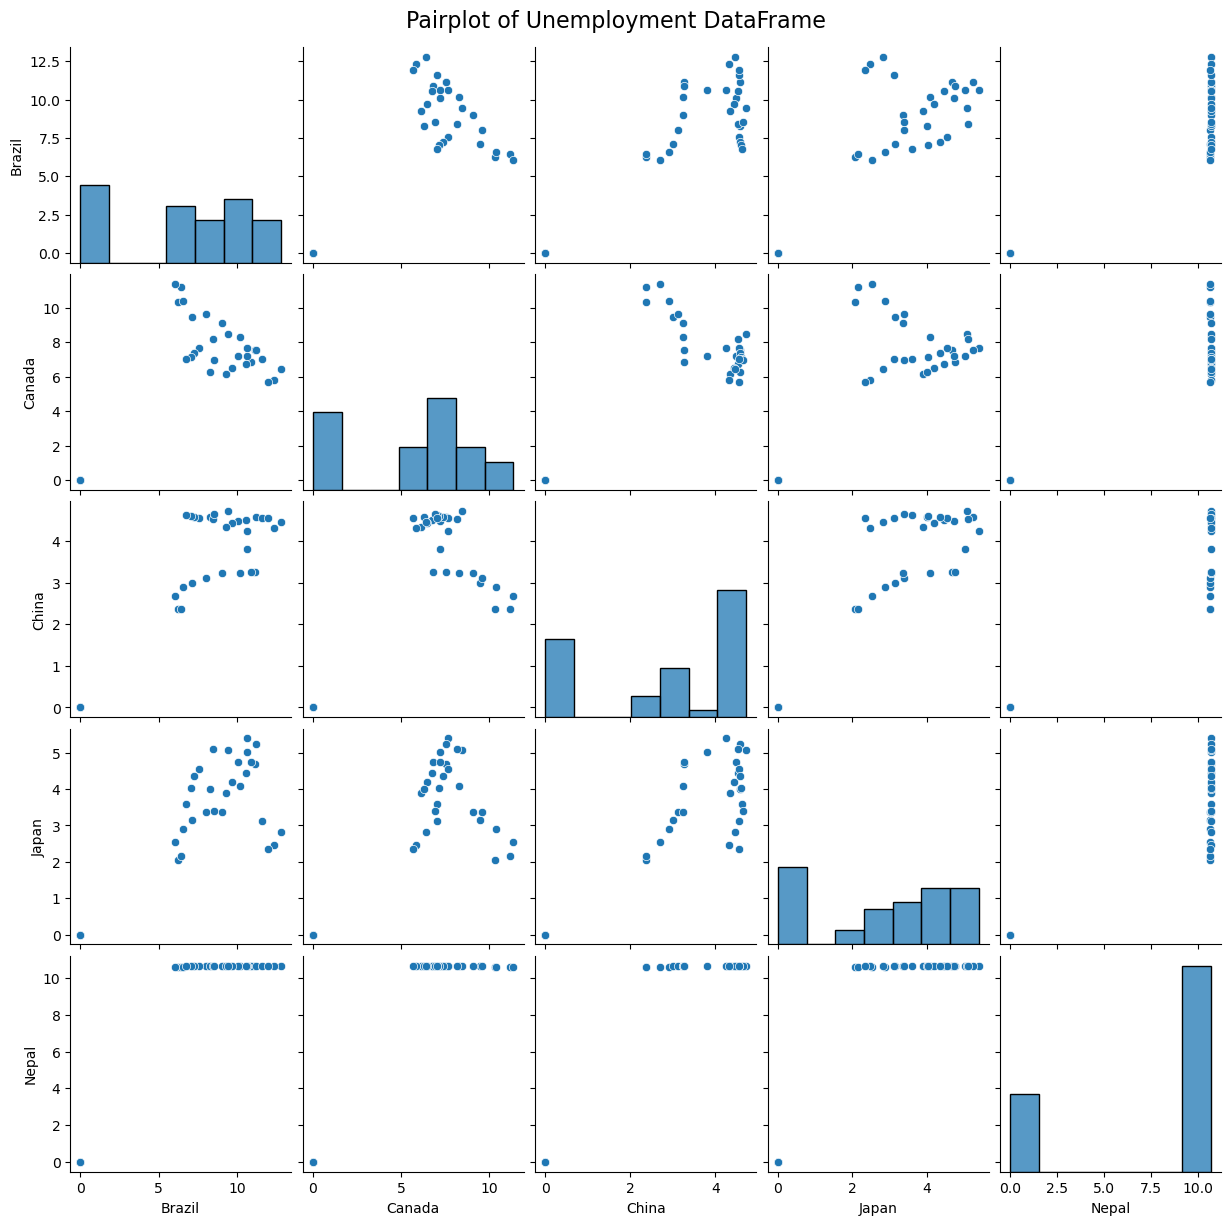

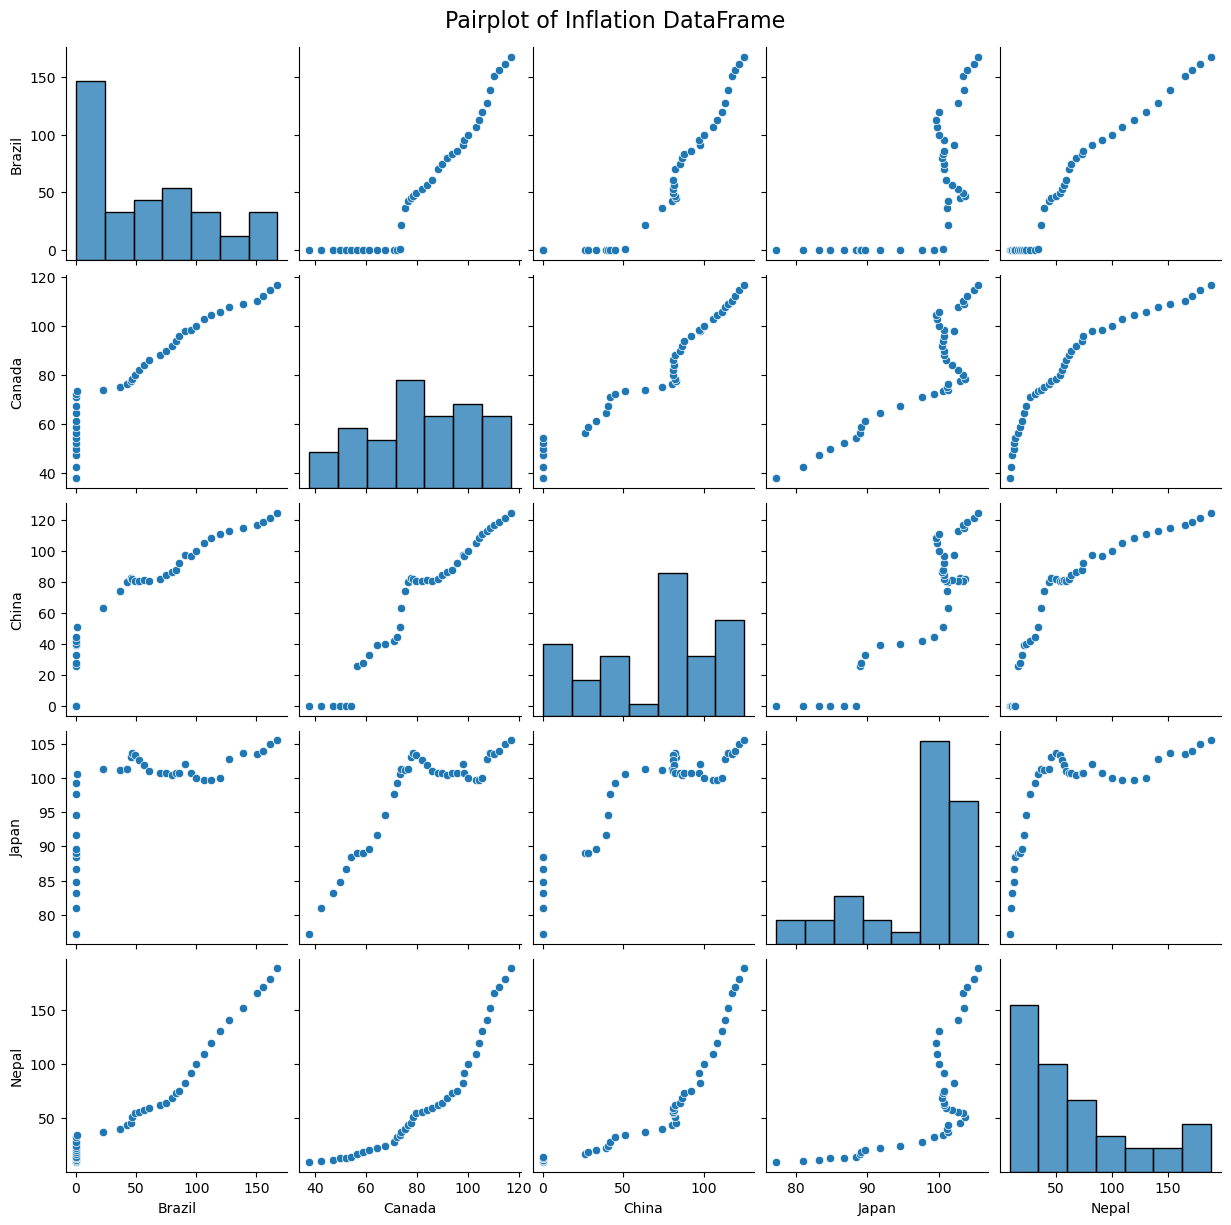

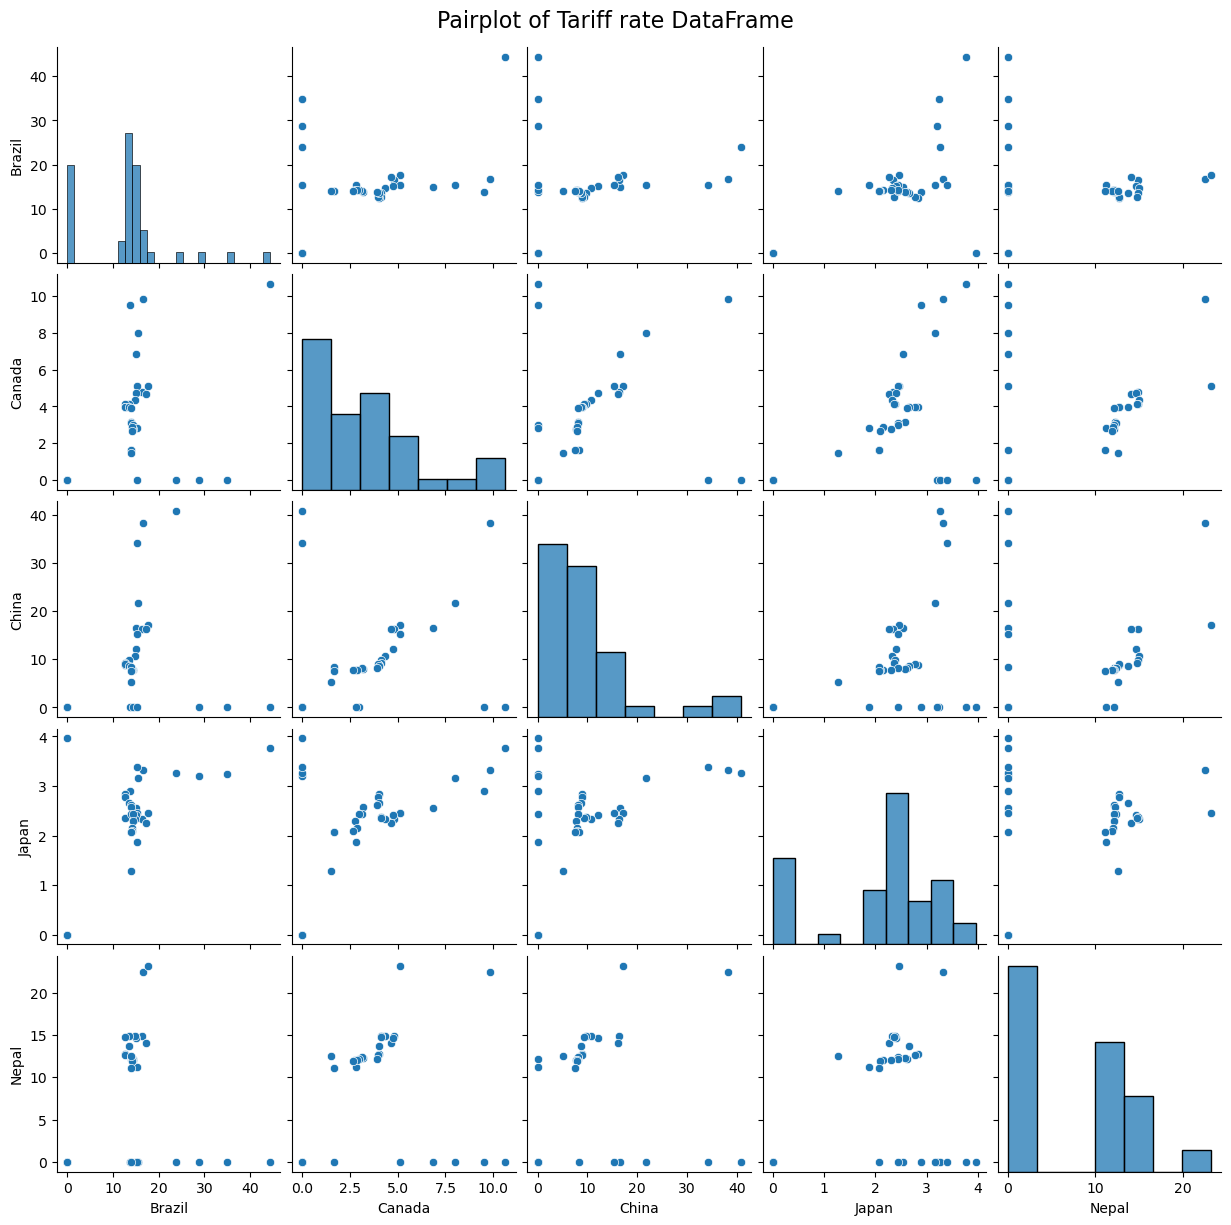

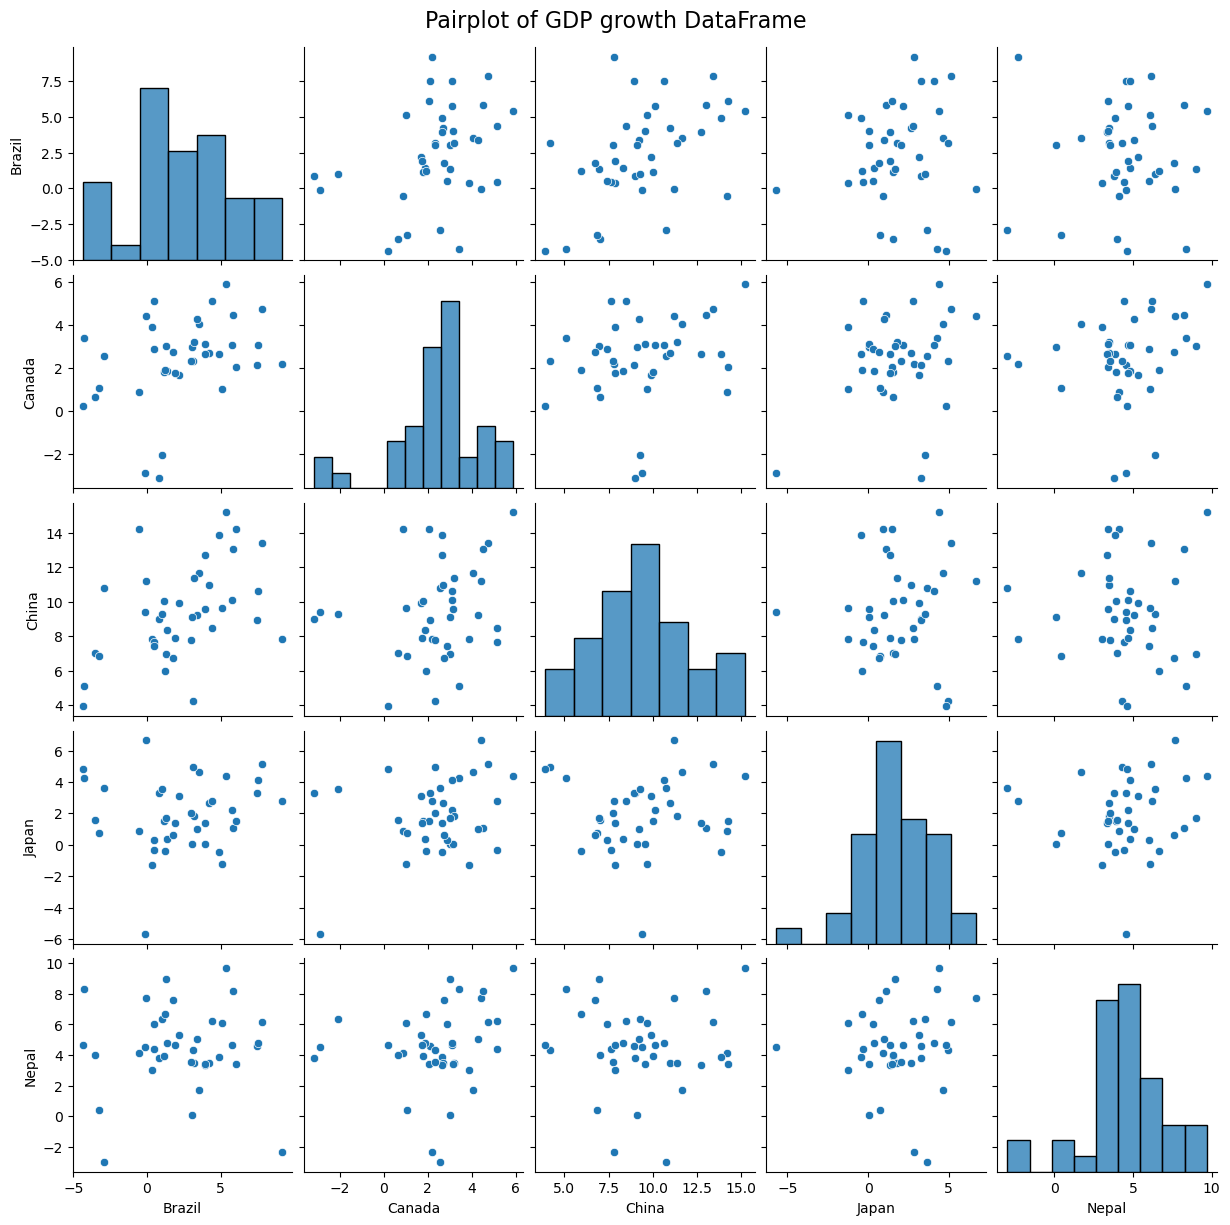

In [10]:
# We use pairplot in seaborn here to show how much is different country influencing each other on a certain indicator 
for (name, df) in dfs.items():
    pairplot = sns.pairplot(df)

    plt.subplots_adjust(top=0.95)
    pairplot.fig.suptitle(f'Pairplot of {name}', fontsize=16)

    plt.show()

- After that we **explore relations between indicators**

- This code **creates heatmaps to visualize the correlations** between different indicators for various countries. Each heatmap displaying the strength and direction of relationships between indicators using a color gradient. Additionally, an average heatmap is computed by taking the mean of all individual correlation matrices, providing a consolidated view of overall trends and patterns in the data across all countries.

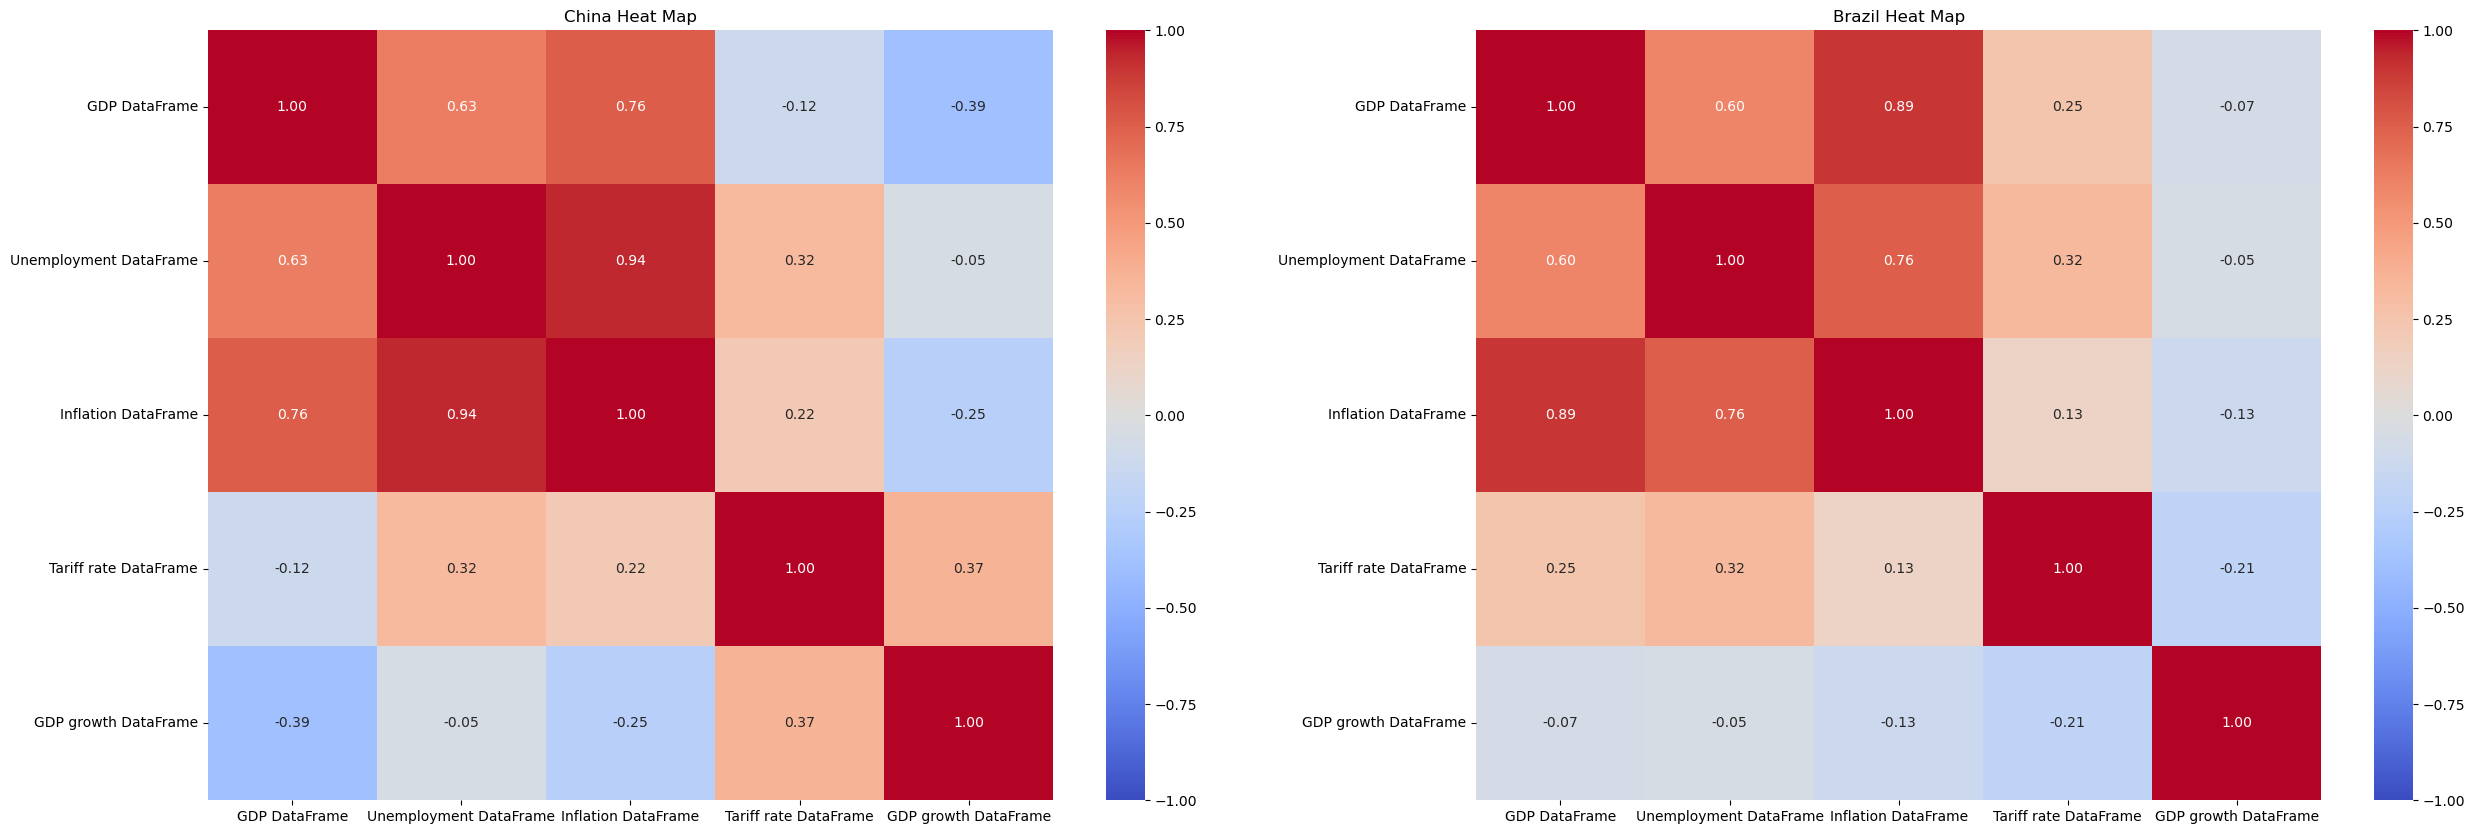

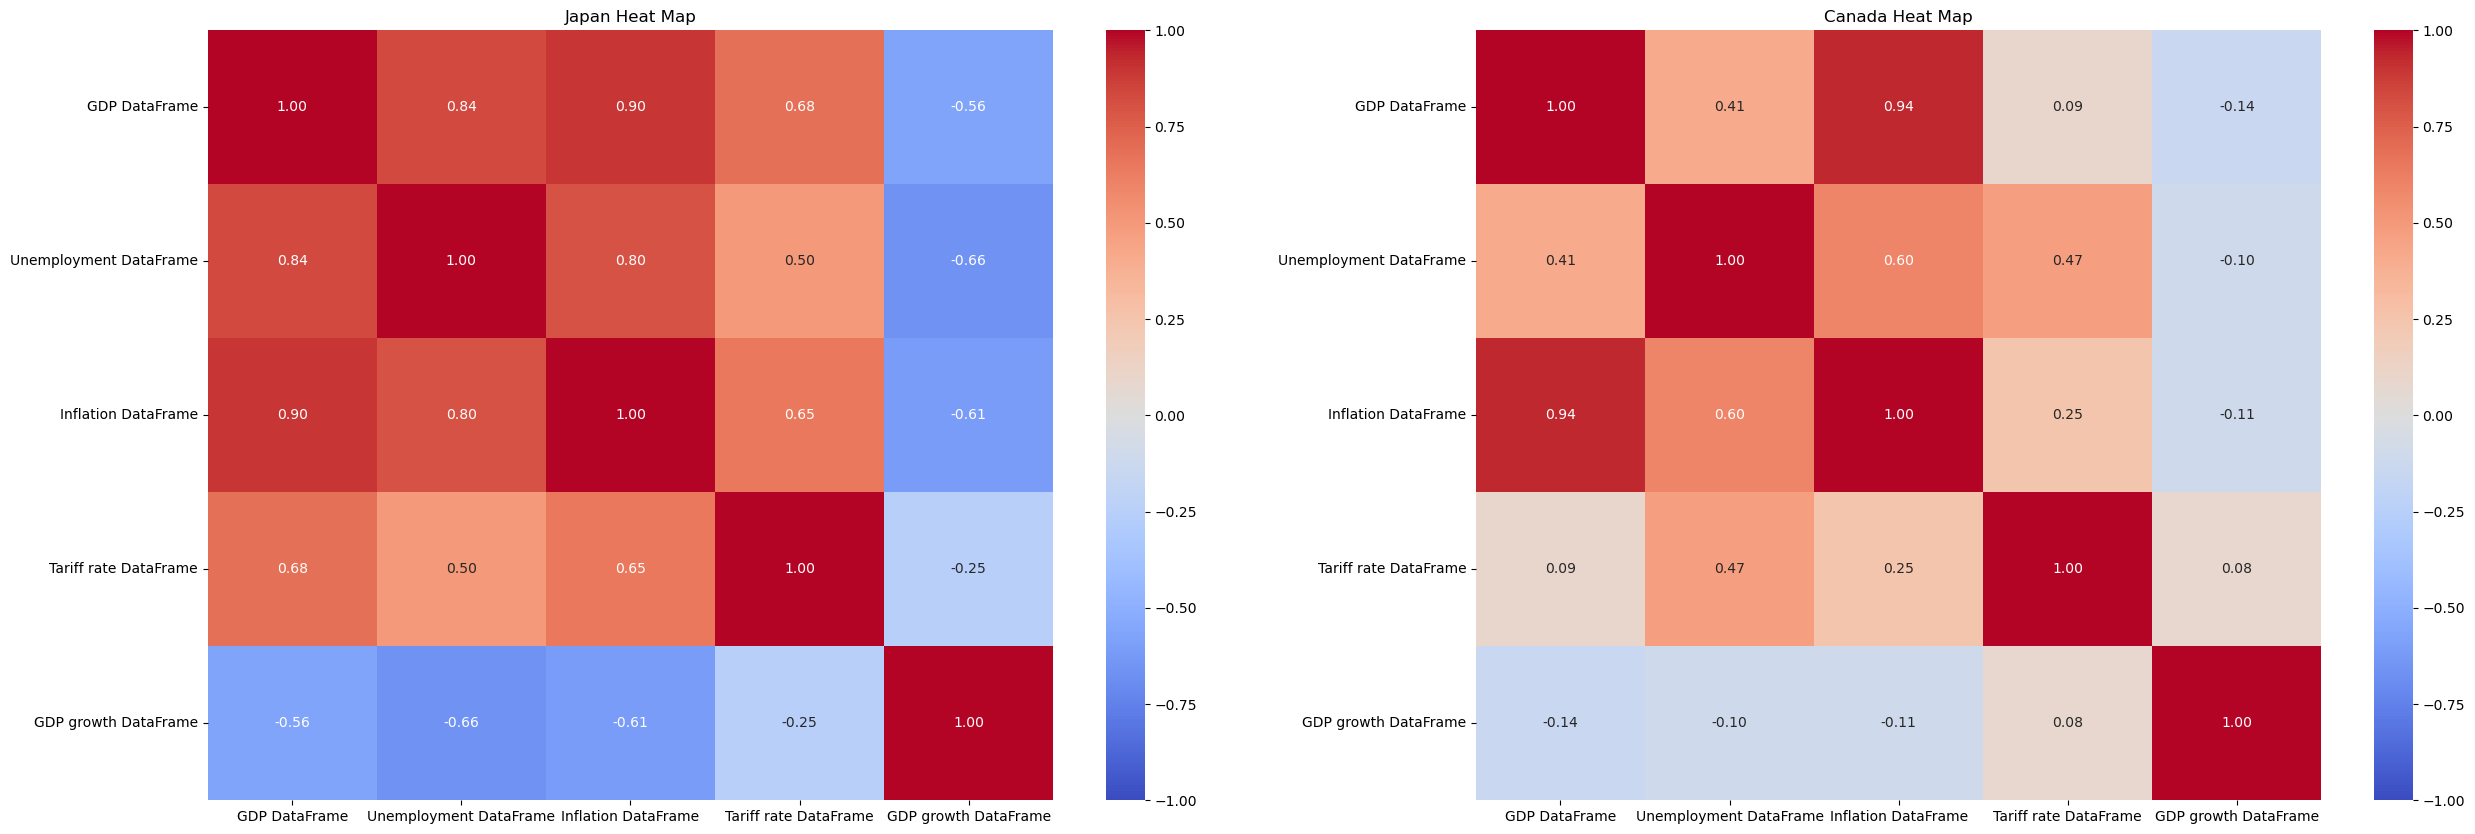

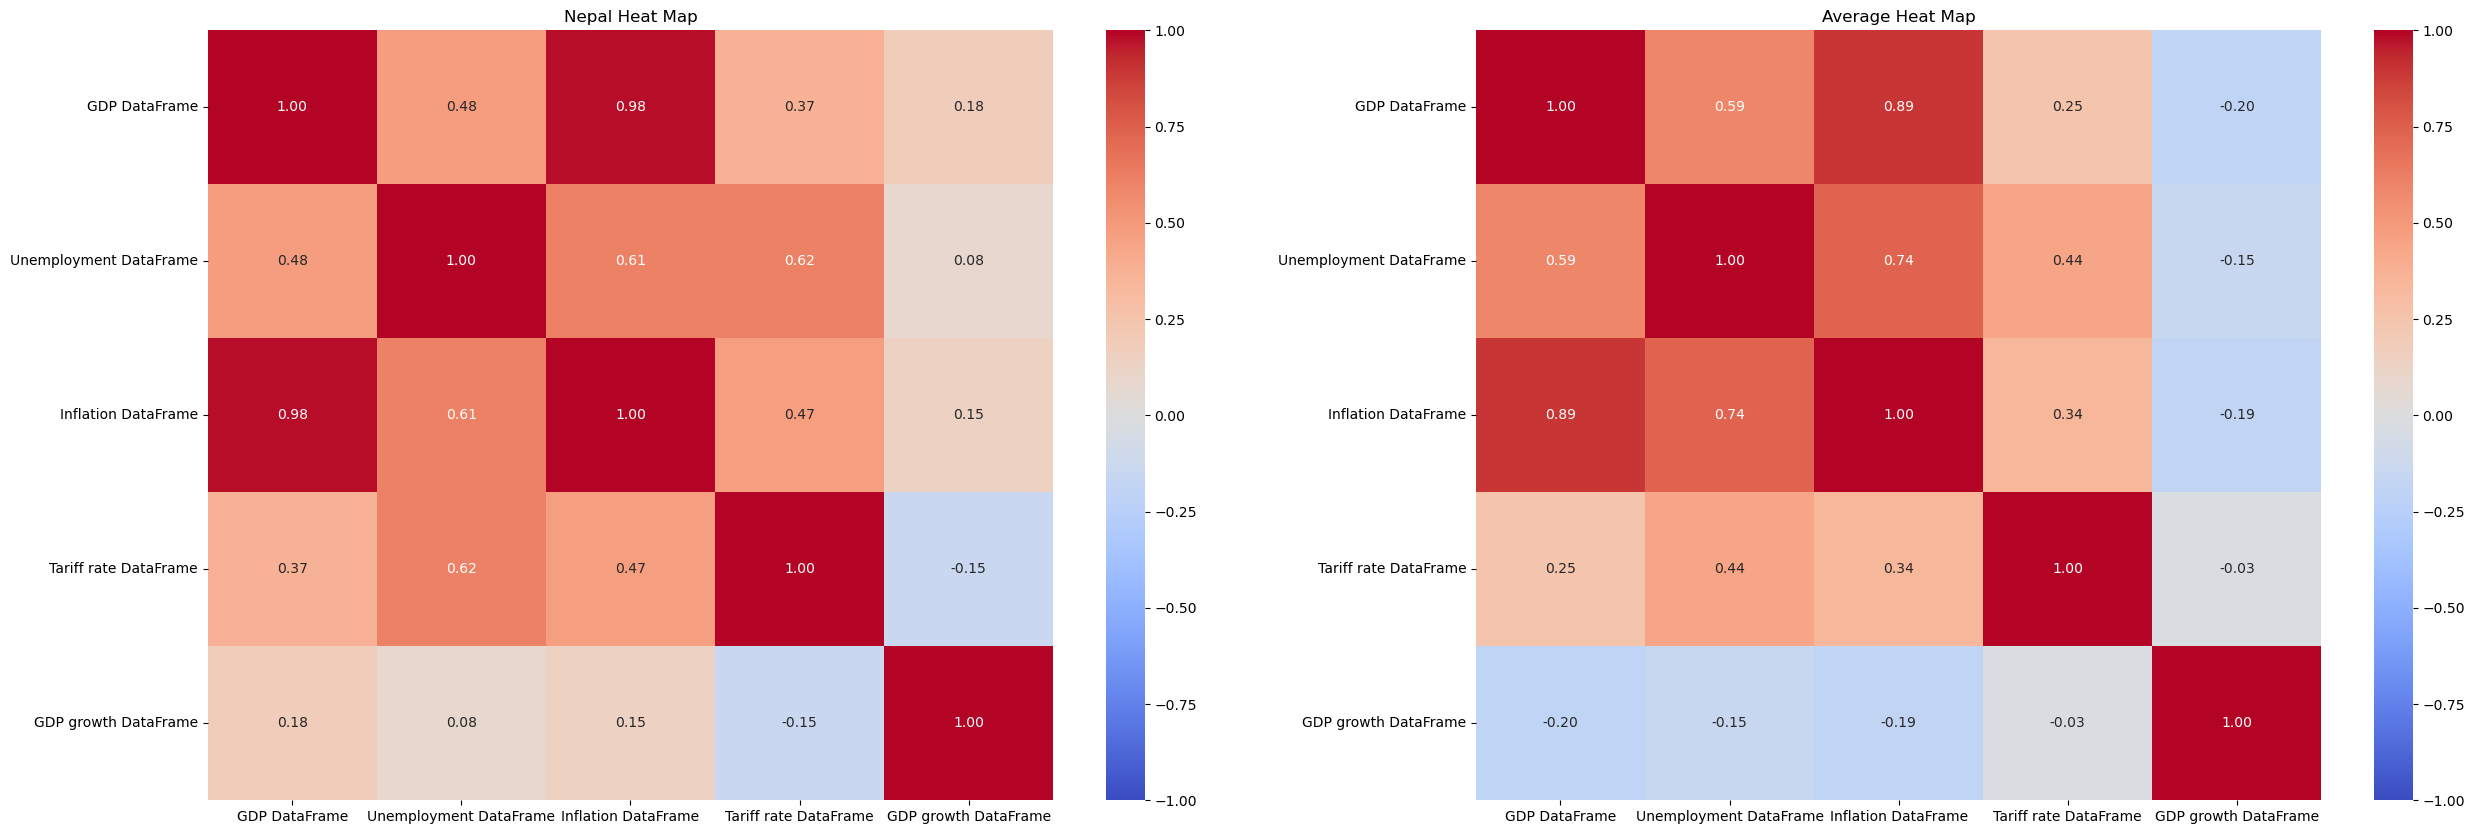

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig, axs = plt.subplots(1, 2, figsize=(30, 10))
sns.heatmap(df_corrs['China'], ax=axs[0], cmap='coolwarm', annot=True, fmt=".2f", vmin=-1, vmax=1)
axs[0].set_title(f'China Heat Map')

sns.heatmap(df_corrs['Brazil'], ax=axs[1], cmap='coolwarm', annot=True, fmt=".2f", vmin=-1, vmax=1)
axs[1].set_title(f'Brazil Heat Map')

plt.show()

fig, axs = plt.subplots(1, 2, figsize=(30, 10))
sns.heatmap(df_corrs['Japan'], ax=axs[0], cmap='coolwarm', annot=True, fmt=".2f", vmin=-1, vmax=1)
axs[0].set_title(f'Japan Heat Map')

sns.heatmap(df_corrs['Canada'], ax=axs[1], cmap='coolwarm', annot=True, fmt=".2f", vmin=-1, vmax=1)
axs[1].set_title(f'Canada Heat Map')

plt.show()

fig, axs = plt.subplots(1, 2, figsize=(30, 10))
sns.heatmap(df_corrs['Nepal'], ax=axs[0], cmap='coolwarm', annot=True, fmt=".2f", vmin=-1, vmax=1)
axs[0].set_title(f'Nepal Heat Map')

# In order to identify the total trend, we calculate the average value of all the correlation matrix, and show it in one chart
mean_corr_matrix = pd.DataFrame(np.mean([df_corr.values for df_corr in df_corrs.values()], axis=0)) # calculate mean here
mean_corr_matrix.index = df_corrs['China'].index
mean_corr_matrix.columns = df_corrs['China'].columns

sns.heatmap(mean_corr_matrix, ax=axs[1], cmap='coolwarm', annot=True, fmt=".2f", vmin=-1, vmax=1)
axs[1].set_title(f'Average Heat Map')

plt.show()

- Creating box plots for the GDP growth rates of different countries allows for a quick visual comparison of their economic performance. Box plots summarize key statistics like the median, quartiles, and outliers, making it easy to identify trends, variability, and unusual data points across countries. It simplifies complex data, helping to highlight differences and similarities in GDP growth rates effectively.

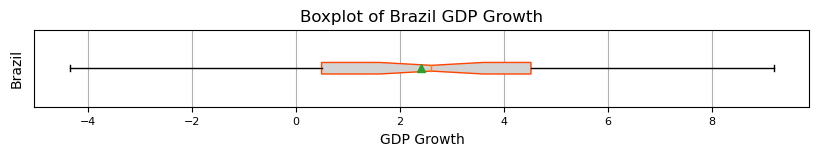

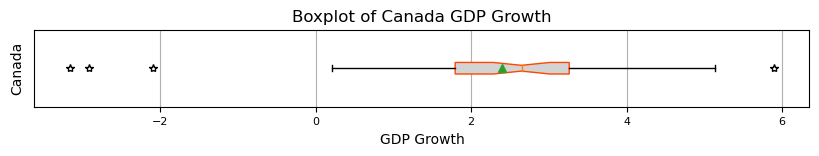

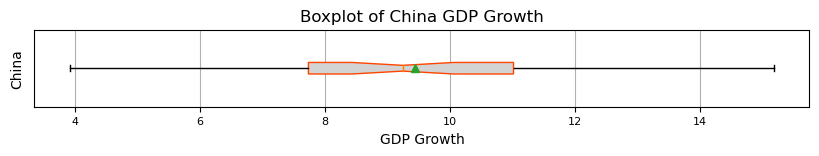

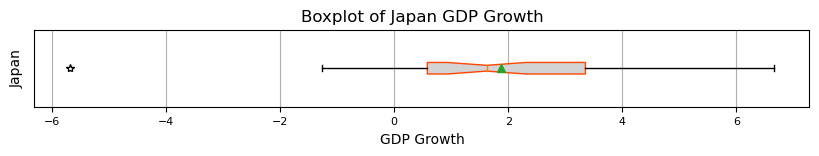

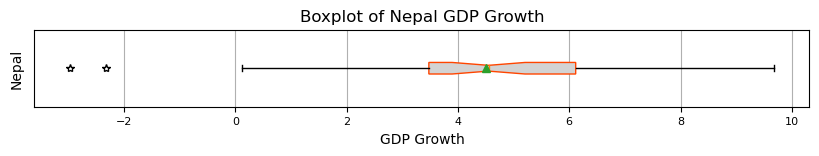

In [12]:
import matplotlib.pyplot as plt


# Loop through each column of gdp growth df
for column in gdp_growth_df.columns:
    # Create a box diagram
    plt.figure(figsize=(10, 1))  # Set the size of the graph
    plt.boxplot(gdp_growth_df[column], notch=True, sym='*', vert=False, showmeans=True, patch_artist=True,
                boxprops={'color': 'orangered', 'facecolor': 'lightgray'})  # Make the background color darker
    plt.xlabel('GDP Growth')  # Set the X-axis label
    plt.ylabel(column)  # Set the Y-axis label to the current column name
    plt.title(f'Boxplot of {column} GDP Growth')
    plt.xticks(fontsize=8)
    plt.yticks(ticks=[], labels=[])
    plt.grid(axis='x')
    plt.show()

## Step5: Interpretation 

- From `GDP Growth by Country and Year Picture`, we find that:  
  - Over the past 40 years or so, the average GDP of all countries has been growing steadily, which shows that the world economy has been improving steadily in recent years
  - Before 2010, the light green bar is the highest, which indicates that Japan's economic situation is the best among the five countries, and the bar representing Japan almost completely covers the other countries before 1991, which indicates that Japan's economy had a great advantage before 1991
  - But since 2010, China's economy has surpassed Japan's, and the red highlight has increased with each year, which indicates that China's economy has opened a wider gap with other countries

- From `Line chart of different indicators`, we find that:  
  - As for the unemployment rate, we can see that the unemployment rate of all countries was relatively high from 1999 to 2004, and then the unemployment rate of most countries declined steadily.
  - As for the inflation rate, we can find that the inflation rate of various countries has been rising continuously since 1980, and the inflation rate of Nepal has risen most seriously, which may be due to domestic unrest and unstable external environment.
  - We can find that the tariff rates of all countries have been gradually declining since 1980, which shows the continuous progress and opening of world trade.
  - GDP growth rate reflects the development speed of a country. We can find that the GDP of all countries fluctuates around a certain average value, among which the GDP growth rate of China is particularly obvious.

- From `pair plots`, we find that:
  - Countries show no correlation across most of the metrics.
  - But there are two indicators that show a strong positive correlation, one is GDP and the other is tariffs.
  - To some extent, the positive correlation of GDP can reflect the synergistic relationship and trade between countries. Take China for example, the GDP of China and Nepal shows a strong positive correlation, which indicates that the trade between the two countries is relatively frequent, or both countries are in a period of rapid growth.
  - In terms of tariff level, most countries show a positive correlation, which largely reflects the world economic trend and environment.

- From `heatmaps`, we can  analyze **correlations or anomalies found between different economic indicators**:
  - The correlation between most indicators in the heat map fluctuates around 0, which means that there is no strong correlation between most indicators.
  - The total amount of GDP is closely related to the level of inflation, which also reveals that GDP does not directly reflect a country's prosperity.
  - At the same time, high unemployment is also closely related to the level of inflation, which may occur at the same time when the country's economic situation is not good.
  - Another point is that tariffs are positively correlated with the unemployment rate, which may be caused by the decline of domestic economic conditions leading to an increase in unemployment and an increase in tariffs.

- From `box-plot picture`, we find that:
  - The median, mean, and outliers of GDP growth rates are clearly represented in the boxplots, and we find that GDP growth rates differ significantly across countries.
  - In this chart, China's GDP growth rate is significantly higher than other countries (as can be seen from the green triangle in the chart). This is in line with the current international economic situation.
  - Japan, Canada, and Nepal have a negative outlier, which indicates that in some years, these countries have experienced severe negative GDP growth.We guess it may be related to the economic crisis or the pandemic crisis

- Abnormal
    - The heatmap shows a correlation of approximately 0.6 between high unemployment and total GDP, suggesting that higher unemployment might be associated with higher GDP, which is challenging to explain.

    - The pair chart indicates that tariff rates between countries do not exhibit a strong correlation. However, in general, tariff rates can influence each other.

    - The inflation rates of five countries were all 100 in 2011, which seems highly coincidental. However, the data verified on the official website is correct, and no errors were found in data processing.

    - The unemployment rate in Nepal has consistently been around 10.6% for the past 30 years, which seems unusual. If the data is accurate, it reflects a long-term severe employment situation in Nepal.